# 04. PyTorch Custom Datasets

Let's see how to get own data into PyTorch with custom datasets!

## Domain libraries

Depending on what you work with, you'll want to look into each of the PyTorch domain libraries for existing data loading and customizing functions.

In [1]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

We have a subset of the Food101 dataset which has 101 different classes of food and a 1000 images per class. We only have 3 classes of food and ~10% of the images.

Why? Start small, increase when necessary!

In [94]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak, sushi data...


## 2. Becoming One with the Data (Data Preparation and Exploration)

In [95]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contens."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [96]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 167 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 163 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 73 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 66 images in 'data/pizza_steak_sushi/test/pizza'.


In [97]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an Image

Let's write some code to:
1. Get all of the image paths
2. Pick a random one with `random.choice()`
3. Get the image class name with `pathlib.Path.parent.stem`
4. Let's open the image with Python's PIL
5. We'll show the image and print metadata

data/pizza_steak_sushi/train/pizza/3478964.jpg
pizza
Random image path: data/pizza_steak_sushi/train/pizza/3478964.jpg
Image class: pizza
Image height: 512
Image width: 512


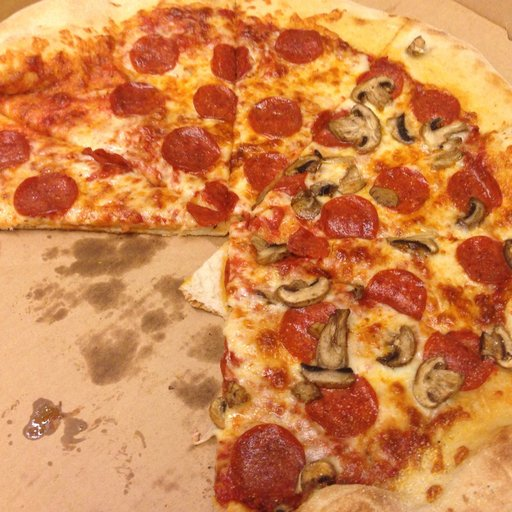

In [98]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

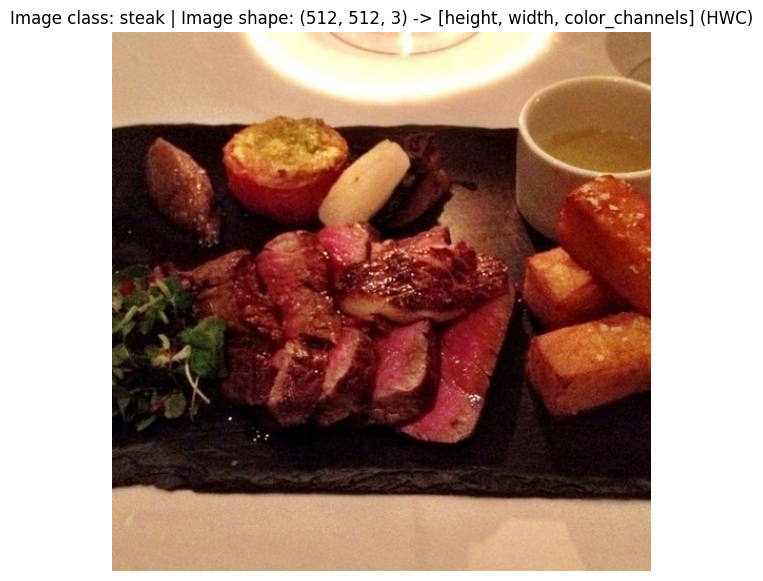

In [8]:
# Also with mathplotlib
import numpy as np
import matplotlib.pyplot as plt

# Image into array
img_as_array = np.asarray(img)

# Plot it
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

array([[[211, 176, 138],
        [209, 174, 136],
        [207, 172, 134],
        ...,
        [159, 117,  69],
        [156, 114,  66],
        [159, 117,  69]],

       [[210, 175, 137],
        [208, 173, 135],
        [206, 171, 133],
        ...,
        [156, 114,  66],
        [157, 115,  67],
        [162, 120,  72]],

       [[208, 173, 135],
        [206, 171, 133],
        [205, 170, 132],
        ...,
        [155, 113,  65],
        [158, 116,  68],
        [161, 119,  71]],

       ...,

       [[201, 158, 126],
        [200, 157, 125],
        [201, 158, 124],
        ...,
        [207, 165, 123],
        [205, 163, 121],
        [202, 160, 118]],

       [[202, 157, 126],
        [200, 155, 124],
        [199, 156, 122],
        ...,
        [205, 163, 121],
        [204, 162, 120],
        [201, 159, 117]],

       [[202, 157, 126],
        [199, 154, 123],
        [198, 155, 121],
        ...,
        [205, 163, 121],
        [204, 162, 120],
        [202, 160, 118]]], dtype=uint8)
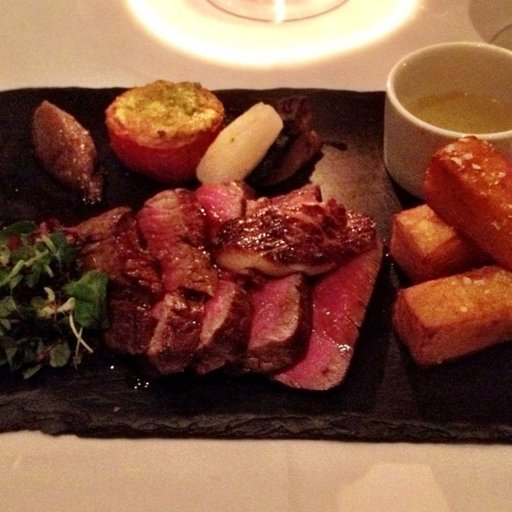

In [9]:
img_as_array

## 3. Transforming Data

Before we can use our data with PyTorch:
1. Turn your target data into tensors
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming Data with `torchvision.transforms`

In [99]:
# Transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), # resize to 64x64
    transforms.RandomHorizontalFlip(p=0.5), # flip images
    transforms.ToTensor() # turn into a tensor
])

In [12]:
data_transform(img)

tensor([[[0.8118, 0.8118, 0.8078,  ..., 0.6471, 0.6314, 0.6235],
         [0.8078, 0.8157, 0.8118,  ..., 0.6392, 0.6353, 0.6314],
         [0.8235, 0.8196, 0.8118,  ..., 0.6431, 0.6431, 0.6431],
         ...,
         [0.7843, 0.7922, 0.7961,  ..., 0.8078, 0.8039, 0.8000],
         [0.7922, 0.7922, 0.7961,  ..., 0.8118, 0.8078, 0.8000],
         [0.7882, 0.7882, 0.7922,  ..., 0.8078, 0.8000, 0.8039]],

        [[0.6745, 0.6745, 0.6706,  ..., 0.4627, 0.4588, 0.4549],
         [0.6706, 0.6745, 0.6784,  ..., 0.4510, 0.4549, 0.4549],
         [0.6745, 0.6745, 0.6745,  ..., 0.4510, 0.4667, 0.4667],
         ...,
         [0.6275, 0.6275, 0.6314,  ..., 0.6431, 0.6471, 0.6431],
         [0.6275, 0.6275, 0.6275,  ..., 0.6510, 0.6510, 0.6510],
         [0.6275, 0.6392, 0.6275,  ..., 0.6588, 0.6549, 0.6510]],

        [[0.5216, 0.5137, 0.5137,  ..., 0.3020, 0.2941, 0.2745],
         [0.5098, 0.5098, 0.5176,  ..., 0.2941, 0.2902, 0.2784],
         [0.5137, 0.5098, 0.5098,  ..., 0.2902, 0.3020, 0.

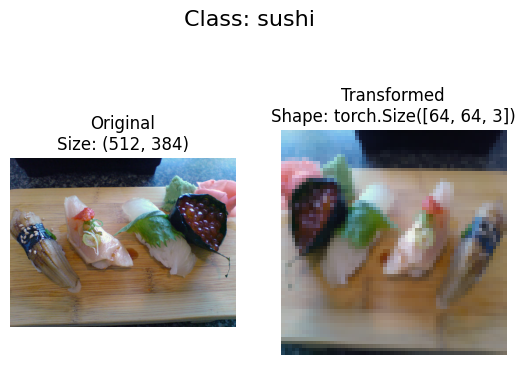

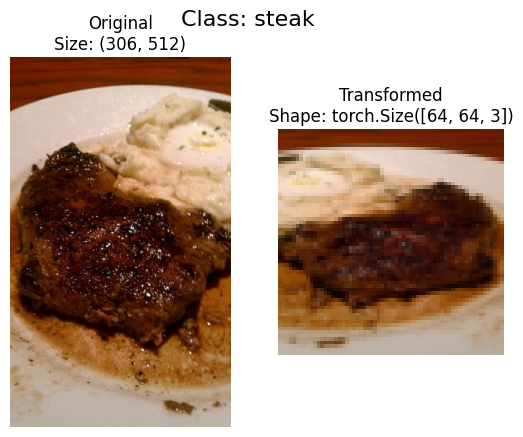

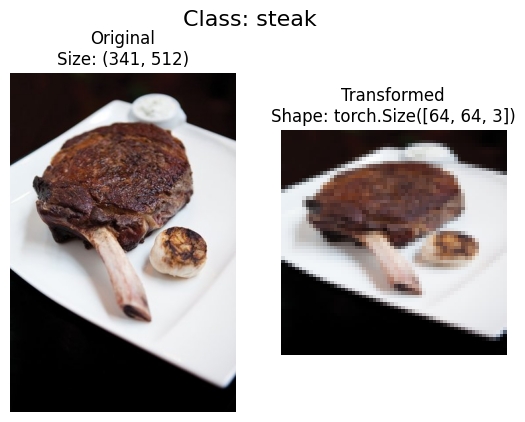

In [13]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and transforms them and plots the original vs the transformed version.
  """
  if seed:
    random.seed(42)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3)

## 4. Option 1: Loading Image Data with `ImageFolder`

We can load image classification data with `torchvision.datasets.ImageFolder`

In [100]:
# Let's create dataset(s) with ImageFolder
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\n\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 480
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

Test data:
Dataset ImageFolder
    Number of datapoints: 211
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [15]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [16]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
len(train_data), len(test_data)

(225, 75)

In [19]:
# Index on train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Permuted shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


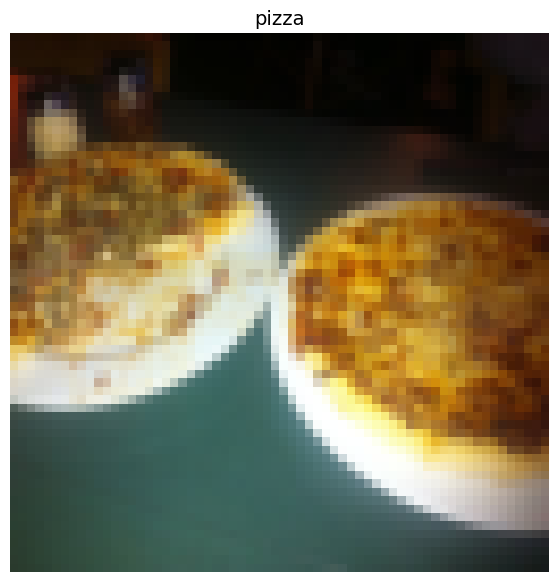

In [20]:
img_permute = img.permute(1, 2, 0)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Permuted shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False);
plt.title(class_names[label], fontsize=14);

### 4.1 Turn Loaded Images into `DataLoader`'s

A `DataLoader` helps us turning the `Dataset`'s into iterables with batches!

In [101]:
# Turn train and test datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

In [22]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost everything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost everything, it does not mean it will work...
* Using a custom `Dataset` often results in us writing more code, which may be prone to errors or performance issues

In [23]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [24]:
# Instance of torchvision.datasets.ImageFolder
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally in standard image classification format)
2. Raise an error if the class names are not found (something wrong with the directory structure)
3. Turn the class names into a dict and a list, and return them

In [102]:
# Target directory path
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get class names as a list
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [103]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}, please check the file structure.")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [27]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (where we'd like to get data from) as well as a transform if we'd like to transform our data
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - target classes
  * class_to_idx - a dict of the target classes mapped to int labels
4. Create a function to `load_images()` to open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index


In [104]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform = None):
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # get all image paths
    self.transform = transform # optional
    self.classes, self.class_to_idx = find_classes(targ_dir) # get class names and map them to idx

  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data; data and label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]
    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [105]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [106]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                   transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                  transform=test_transforms)

In [107]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7e34b7c805d0>,
 <__main__.ImageFolderCustom at 0x7e34b7c83cd0>)

In [32]:
len(train_data), len(train_data_custom)

(225, 225)

In [33]:
len(test_data), len(test_data_custom)

(75, 75)

In [34]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [35]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [36]:
# Check for equality between original ImageFolder and ImageFolderCustom
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True


### 5.3 Create a Function to Display Random Images

1. Take in a `Dataset` and some other parameters...
2. To prevent the display getting out of hand, let's cap the max number of images to be seen at 10
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset
5. Set up a matplotlib plot
6. Look through random image indexes and plot them
7. Make sure the image dimensions match with matplotlib (HWC)

In [37]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  if n > 10:
    n = 10
    display_shape = False
    print(f"Hey! Note, n <= 10, shape display is now off")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n) # k random indexes

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0) # (C, H, W) -> (H, W, C)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
      plt.title(title)
    plt.title(title)

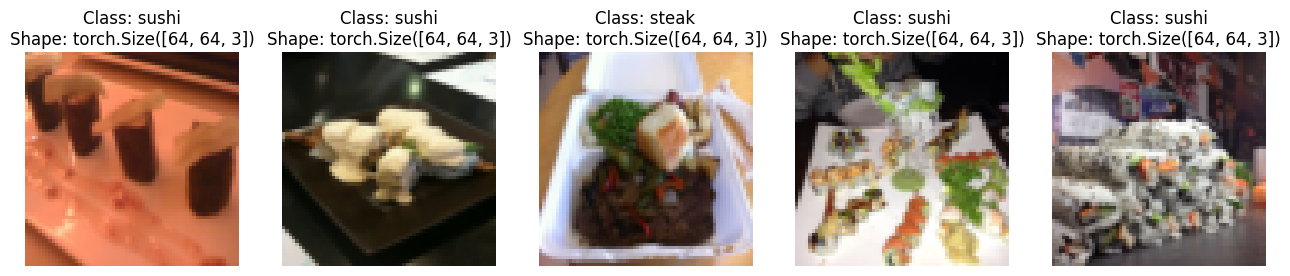

In [38]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

Hey! Note, n <= 10, shape display is now off


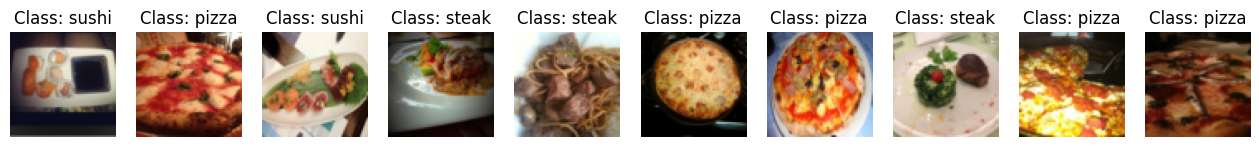

In [39]:
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4 Turn Custom Loaded Images into `DataLoader`'s

In [108]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=1,
                                      shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=1,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7e34b7c61750>,
 <torch.utils.data.dataloader.DataLoader at 0x7e34d2eb4ad0>)

In [109]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other Forms of Transforms (Data Augmentation)

Data augmentation is the process of artificially adding diversity to training data; with image data, it may mean applying different image transforming to training data. Hopefully this leads into more generalizable model to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

In [110]:
# Let's look at trivialaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [43]:
image_path

PosixPath('data/pizza_steak_sushi')

In [111]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/359330.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/482022.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3470083.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/214320.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3142674.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2287136.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1049459.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3807440.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/239025.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2878151.jpg')]

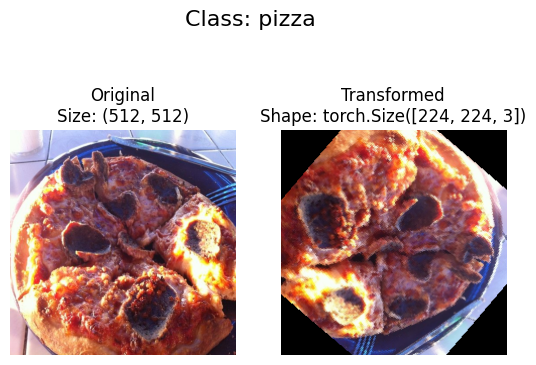

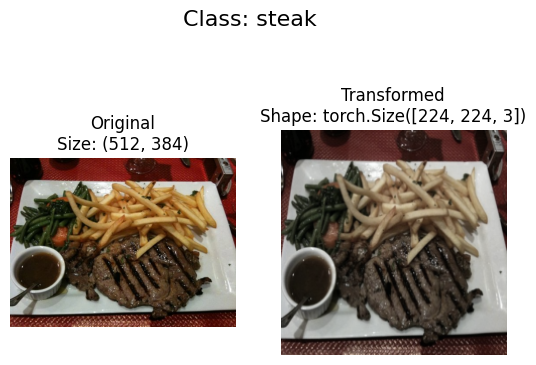

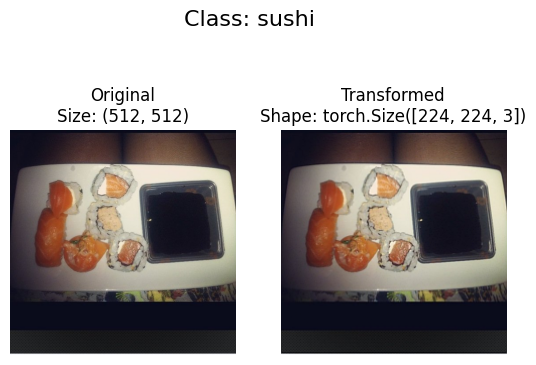

In [45]:
# Plot transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3)

## 7. Model 0: TinyVGG Without Data Augmentation

Let's replicate this architecture from the CNN Explainer website.

## 7.1 Creating Transforms and Loading Data for Model 0

In [46]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [112]:
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                        transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                       transform=simple_transform)

import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG Model

In [48]:
class TinyVGG(nn.Module):
  """ Building a model architecture copied from CNN Explainer."""
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # devault stride = kernel size
    )
    self.conv_block_2 = nn.Sequential(
    nn.Conv2d(in_channels=hidden_units,
              out_channels=hidden_units,
              kernel_size=3,
              stride=1,
              padding=0),
    nn.ReLU(),
    nn.Conv2d(in_channels=hidden_units,
              out_channels=hidden_units,
              kernel_size=3,
              stride=1,
              padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,
                     stride=2) # devault stride = kernel size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [91]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Test the Forward Pass

In [50]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [51]:
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to Get an Idea of the Shapes within the Model

In [52]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0,
        input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create Train and Test Loop Functions

In [53]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Computing accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [54]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Computing accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train` Function to Combine the Steps

In [55]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

  # Let's create a dict for results
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

### 7.7 Train and Evaluate model_0

In [113]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

model_0 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1003 | Train Acc: 0.3167 | Test Loss: 1.0919 | Test Acc: 0.3365
Epoch: 1 | Train Loss: 1.0610 | Train Acc: 0.4250 | Test Loss: 1.0463 | Test Acc: 0.4730
Epoch: 2 | Train Loss: 0.9650 | Train Acc: 0.5500 | Test Loss: 0.9230 | Test Acc: 0.5630
Epoch: 3 | Train Loss: 0.8469 | Train Acc: 0.6167 | Test Loss: 0.9502 | Test Acc: 0.5209
Epoch: 4 | Train Loss: 0.8258 | Train Acc: 0.6167 | Test Loss: 0.9407 | Test Acc: 0.5315
Epoch: 5 | Train Loss: 0.7906 | Train Acc: 0.6438 | Test Loss: 0.9204 | Test Acc: 0.5808
Epoch: 6 | Train Loss: 0.7666 | Train Acc: 0.6583 | Test Loss: 0.9457 | Test Acc: 0.5449
Epoch: 7 | Train Loss: 0.7318 | Train Acc: 0.6854 | Test Loss: 0.9888 | Test Acc: 0.5421
Epoch: 8 | Train Loss: 0.7730 | Train Acc: 0.6479 | Test Loss: 0.9121 | Test Acc: 0.5616
Epoch: 9 | Train Loss: 0.7110 | Train Acc: 0.7021 | Test Loss: 0.9176 | Test Acc: 0.5707
Epoch: 10 | Train Loss: 0.6570 | Train Acc: 0.7125 | Test Loss: 0.9548 | Test Acc: 0.5677
Epoch: 11 | Train Lo

In [57]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333287000656,
  1.0662163645029068],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608318249384563,
  1.0653960307439168],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the Loss Curves of model_0

A **loss curve** is a nice way to track model's progress.

In [58]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [59]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """ Plots training curves of a results dictionary. """
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.show()

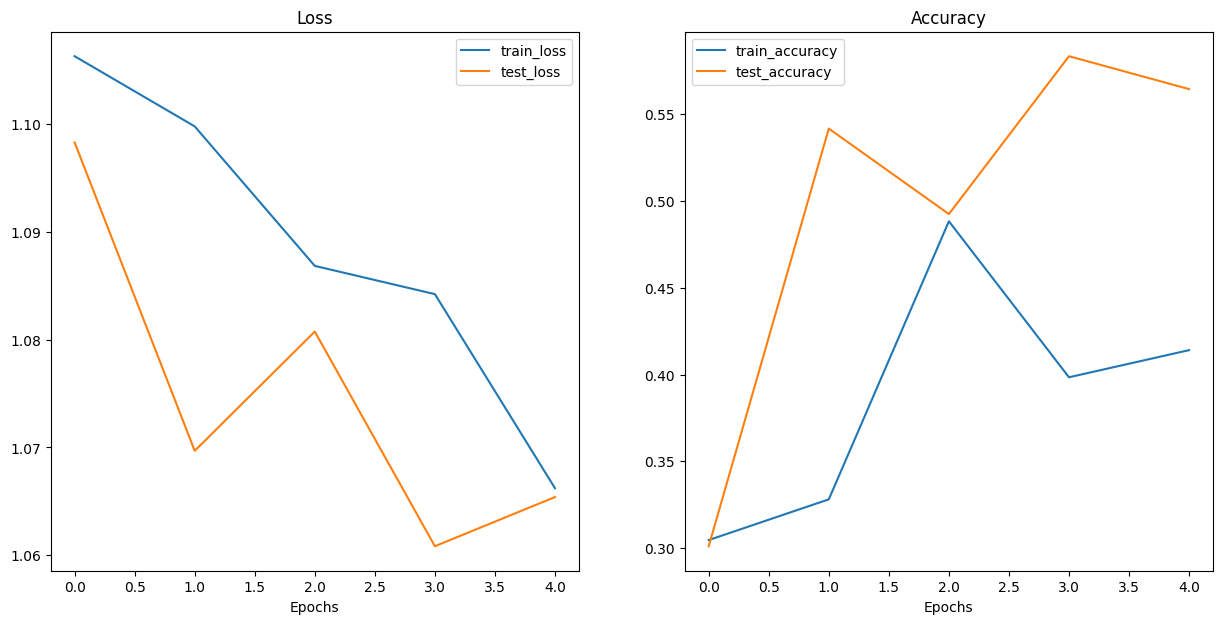

In [60]:
plot_loss_curves(model_0_results)

## 8. What should an Ideal Loss Curve Look Like?

One of the best ways to evaluate model performance...

## 9. Model 1: TinyVGG with Data Augmentation

Let's test the same model with a bit of data augmentation!

In [61]:
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create Train and Test `Dataset`'s and `DataLoader`'s with Data Augmentation

In [62]:
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_augmented = datasets.ImageFolder(root=test_dir,
                                           transform=test_transform_simple)

In [63]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

### 9.3 Constructing and Training model_1

In [64]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [65]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1049 | Train Acc: 0.2500 | Test Loss: 1.1019 | Test Acc: 0.2604
Epoch: 1 | Train Loss: 1.0807 | Train Acc: 0.4258 | Test Loss: 1.1261 | Test Acc: 0.2604
Epoch: 2 | Train Loss: 1.0712 | Train Acc: 0.4258 | Test Loss: 1.1593 | Test Acc: 0.2604
Epoch: 3 | Train Loss: 1.1253 | Train Acc: 0.3047 | Test Loss: 1.1581 | Test Acc: 0.2604
Epoch: 4 | Train Loss: 1.0865 | Train Acc: 0.4258 | Test Loss: 1.1554 | Test Acc: 0.3333
Total training time for model_1: 17.599 seconds


### 9.4 Plot the Loss Curves for model_1

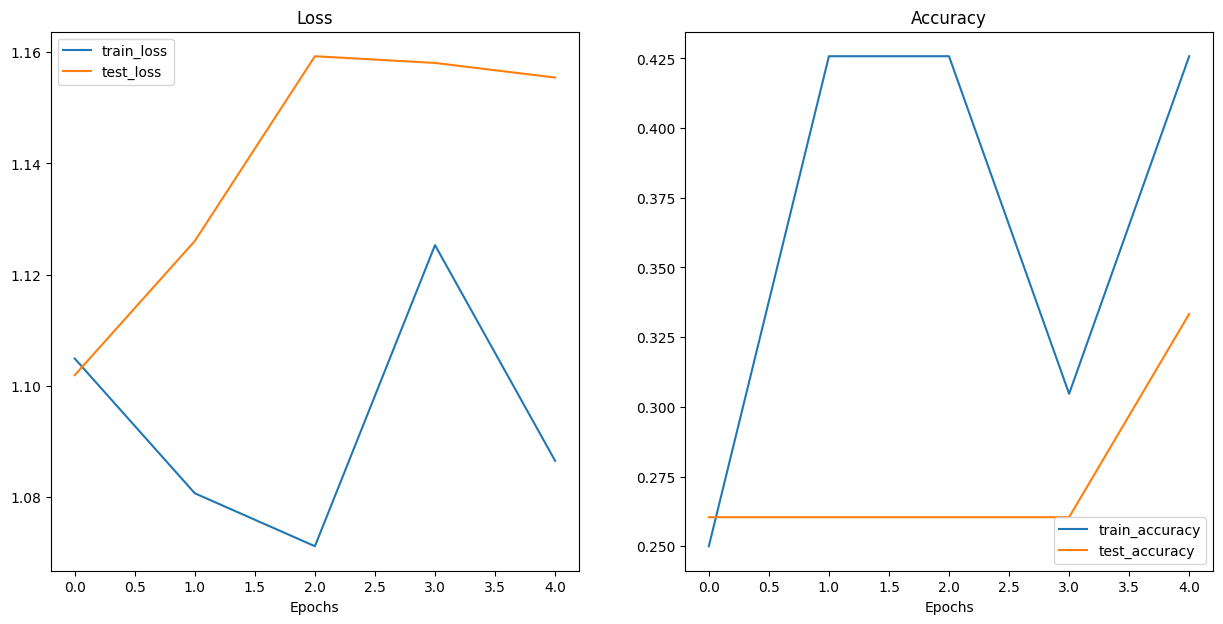

In [66]:
plot_loss_curves(model_1_results)

## 10. Comparing Model Results

Let's compare the results! This time we'll just code manually.

In [67]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

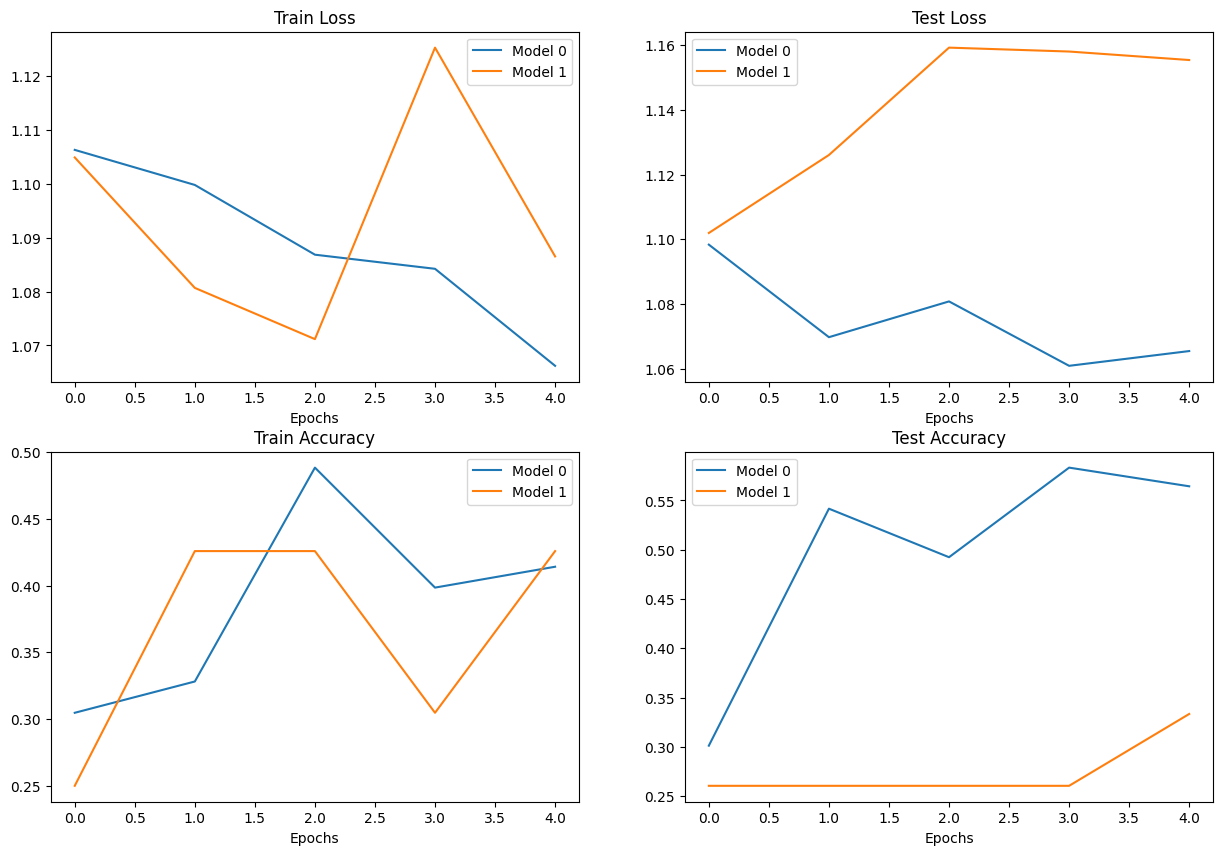

In [68]:
plt.figure(figsize=(15, 10))
epochs = range(len(model_0_df))
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a Prediction on a Custom Image

In [70]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists!")

data/04-pizza-dad.jpeg already exists!


### 11.1 Loading In a Custom Image with PyTorch

The custom image must be in same format that our training data was:
* tensor form, `torch.float32`
* size 64 x 64 x 3 (+ batch size dimension!)
* on right device

In [77]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Shape: {custom_image_uint8.shape}")
print(f"Device: {custom_image_uint8.device}")
print(f"Type: {custom_image_uint8.dtype}")

Shape: torch.Size([3, 4032, 3024])
Device: cpu
Type: torch.uint8


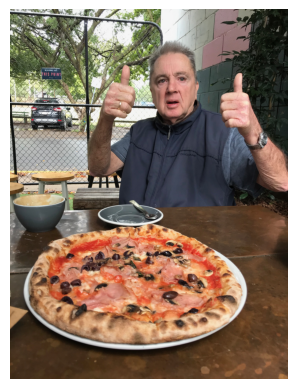

In [75]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));
plt.axis(False);

### 11.2 Let's Predict a Custom Image

In [84]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

custom_image_transformed = custom_image_transform(custom_image)

model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device).unsqueeze(dim=0))

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_class = class_names[custom_image_pred_label]

custom_image_pred_class

'pizza'

### 11.3 Let's Functionize This!

We want a function where to pass an image path and which will output a prediction + visualize the image!

In [85]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device = device):
  """Makes a prediction on a target image with a trained model and plots the image."""
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  target_image = target_image / 255.0 # values between 0 and 1

  if transform:
    target_image = transform(target_image)

  model.to(device)
  model.eval()

  with torch.inference_mode():
    target_image_pred = model(target_image.unsqueeze(dim=0).to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title);
  plt.axis(False);

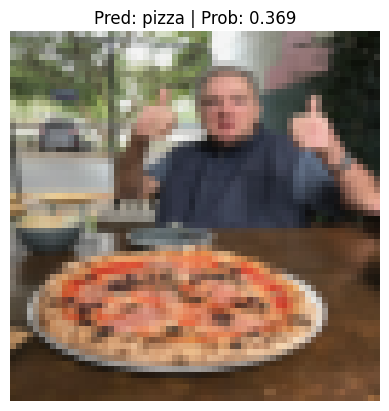

In [89]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)